# About this notebook

This notebook is based on Coursera's course "Machine learning" by Prof. Andrew Ng from Stanford University. In this course, all codes are written in Octave or Matlab. This notebook provides the Python version of the codes.

This notebook is based on the Exerxise 3. Key words are as follows:
- Multi-class classification
- Regularized logistic regression
- One-vs-all logistic regression
- Neural network
- Handwriting recognition

# Multi-class classification

In this part of the notebook, one-vs-all logistic regression will be implemented to recognize handwritten digits (from 0 to 9).

## Preparation of data

Data are prepared in .mat format. 
- ex3data1.mat: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
- ex3weights.mat: dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

The matrix X and vector y in the file "ex3data1.mat" are obtained as X<sub>0</sub> and y, respectively:

$$
    \boldsymbol{X_0} =
        \left[\begin{array}{c}
            x_1^{(1)}& x_2^{(1)} & \dots & x_{n_{pixel}}^{(1)} \\
            x_1^{(2)}& x_2^{(2)} & \dots & x_{n_{pixel}}^{(2)} \\ 
            \vdots & \vdots \\
            x_1^{(m)} & x_2^{(m)} & \dots & x_{n_{pixel}}^{(m)} \\
        \end{array}\right]\quad        
    \boldsymbol{y} =
        \left[\begin{array}{c}
            y^{(1)} \\
            y^{(2)} \\
            \vdots \\            
            y^{(m)} \\
        \end{array}\right] \quad
$$  

Here, X<sub>0</sub> is (m x n<sub>pixel</sub>)-matrix, and y is m-dimensional vector. The integer n<sub>pixel</sub> represents the number of pixels in an image. The integer m is the number of images and can be regarded as the number of training datasets. One image is stored in each row, i.e., j-th image is expressed by

$$
    \boldsymbol{X_0(j)} =
        \left[\begin{array}{c}
            x_1^{(j)}& x_2^{(j)} & \dots & x_{n_{pixel}}^{(j)} \\
        \end{array}\right].\quad        
$$


A new column consisting of 1 is added to the first column of the matrix X<sub>0</sub> to form a new matrix X.

$$
    \boldsymbol{X} =
        \left[\begin{array}{c}
            x_0^{(1)} & x_1^{(1)}& x_2^{(1)} & \dots & x_{n_{pixel}}^{(1)} \\
            x_0^{(2)} & x_1^{(2)}& x_2^{(2)} & \dots & x_{n_{pixel}}^{(2)} \\ 
            \vdots & \vdots & \vdots &   & \vdots  \\
            x_0^{(m)} & x_1^{(m)} & x_2^{(m)} & \dots & x_{n_{pixel}}^{(m)} \\
        \end{array}\right]
        =
        \left[\begin{array}{c}
            1 & x_1^{(1)}& x_2^{(1)} & \dots & x_{n_{pixel}}^{(1)} \\
            1 & x_1^{(2)}& x_2^{(2)} & \dots & x_{n_{pixel}}^{(2)} \\ 
            \vdots & \vdots & \vdots &   & \vdots  \\
            1 & x_1^{(m)} & x_2^{(m)} & \dots & x_{n_{pixel}}^{(m)} \\
        \end{array}\right]\quad
$$

Here, the matrix X has m x n components, where n is the integer that represents the number of features.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat

path=os.getcwd()

datpath1=path + '/ex3data1.mat'
datpath2=path + '/ex3weights.mat'

dat1=loadmat(datpath1)
dat2=loadmat(datpath2)
print(dat1.keys())
print(dat2.keys())

X0=dat1['X']
X=np.insert(X0, 0, 1, axis=1) # Add 1 to the first column of the matrix X0.
y=dat1['y']
theta1=dat2['Theta1']
theta2=dat2['Theta2']

#total number of the whole pixels 
n_pixel=X0.shape[1] 

#number of features
n=X.shape[1] 

#number of datasets  
m=X0.shape[0]

print('The number of training examples of handwritten digits is m = %d'%m)
print('The number of pixels is n_pixel = %d'%n_pixel)
print('The datasize of X is %d x %d'%(X.shape[0],X.shape[1]))
print('The datasize of y is %d x %d'%(y.shape[0],1))
print('The datasize of theta1 is %d x %d'%(theta1.shape[0],theta1.shape[1]))
print('The datasize of theta2 is %d x %d'%(theta2.shape[0],theta2.shape[1]))

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])
The number of training examples of handwritten digits is m = 5000
The number of pixels is n_pixel = 400
The datasize of X is 5000 x 401
The datasize of y is 5000 x 1
The datasize of theta1 is 25 x 401
The datasize of theta2 is 10 x 26


## Visualization of data

As mentioned above, one image is stored as (1 x n<sub>pixel</sub>)-dimensional vector.

$$
    \boldsymbol{X_0(j)} =
        \left[\begin{array}{c}
            x_1^{(j)}& x_2^{(j)} & \dots & x_{n_{pixel}}^{(j)} \\
        \end{array}\right].\quad        
$$
In order to visualize the image, it is convinient to transform this type of vector into (n<sub>f</sub> x n<sub>f</sub>)-matrix, where n<sub>f</sub> is the squre root of n<sub>pixel</sub>. The function "<strong>ConvertVectorToMatrix</strong>" does this transformation. In the present case, n<sub>pixel</sub> = 400 and n<sub>f</sub> = 20.

In [2]:
def ConvertVectorToMatrix(Xf):
#convert (1 x nf*nf) vector into (nf x nf) matrix
    nf= int(np.sqrt(Xf.shape[0]))
    ret = np.zeros([nf,nf])
    
    for j in range(nf):
        n_int=nf*j
        n_fin=nf*(j+1)        

        ret[j]=Xf[n_int:n_fin]
    
    return ret

Hand-written numbers in the training dataset are randomly picked up and shown.

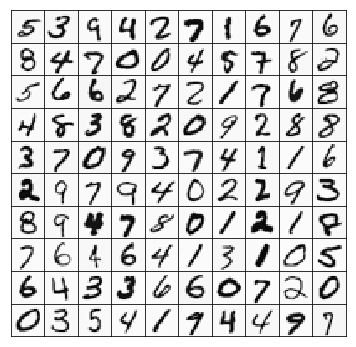

In [3]:
import random

num_fig=100

plt.figure(figsize=(6,6))

for j in range(num_fig):
    plt.subplot(10,10, j+1)
    number=random.randrange(0,m-1,1)
    plt.pcolormesh(np.rot90(ConvertVectorToMatrix(X0[number]),k=1,axes=(0,1)),cmap='Greys')
    plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Definitions of functions

### Hypothesis

The function "<strong>Hypothesis(theta_f,Xf)</strong>" is the hypothesis *h<sub>&theta;</sub>* (*x*) for a logistic regression model. In this code, this function is treated as a (m x 1)-vector.

$$
    \mathrm{Hypothesis}(\theta_f,X_f) = g\bigl([\theta_f^{T} X_f^{T}]^{T}\bigl),
$$

where the parameters &theta;<sub>f</sub> (n x 1 vector) are written by
$$
    \boldsymbol{\theta_f} =
        \left[\begin{array}{c}
            \theta_0 \\
            \theta_1 \\
            \vdots \\            
            \theta_n \\
        \end{array}\right] \quad
$$
and function g is the sigmoid function. The sigmoid function is defined as
$$
        g(z)=\frac{1}{1+e^{-z}}.
$$
In this case, the hypothesis h takes values between 0 and 1.

### Cost function J for regularized logistic regression

The function "<strong>RegLRCostFunctionJ</strong>" returns the cost for specific input of theta parameters. The regularized cost function for logistic regression is given by
$$
    J=\frac{1}{m}\sum_{i=1}^{m}\biggl(-y^{(i)}log\bigl(h_\theta(x^{(i)})\bigl)-(1-y^{(i)})log\bigl(1-h_\theta(x^{(i)})\bigl)\biggl)+\frac{\lambda}{2m}\sum_{j=1}^{n}\theta^2_j.
$$
The final term in the above equation is the regularization term. It should be noted that the parameter &theta;<sub>0</sub> should not be regularized. In the equation above, the second summation is taken from j = 1 (not j = 0) to j = n.

### Partial derivative of regularized logistic regression cost for &theta;<sub>j</sub>

The function "<strong>RegLRGradient</strong>" returns the gradient of the cost function that is a vector where the j-th element is defined as

$$
    \frac{{\partial}J(\theta)}{{\partial}\theta_j}=\frac{1}{m}\sum_{i=1}^{m}\bigl(h_\theta(x^{(i)})-y^{(i)})\bigl)x^{(i)}_j \ \ \ \ \ \ \ (\mathrm{for } j = 0) 
$$

and 

$$
    \frac{{\partial}J(\theta)}{{\partial}\theta_j}=\frac{1}{m}\sum_{i=1}^{m}\bigl(h_\theta(x^{(i)})-y^{(i)})\bigl)x^{(i)}_j + \frac{\lambda}{m}\theta_j \ \ \ \ \ \ \ (\mathrm{for } j \geq 1) 
$$
for i-th trainintg set. If we rewrite these formulae as a vector, it will look like

$$
        \left[\begin{array}{c}
            \frac{{\partial}J(\theta)}{{\partial}\theta_0} \\
            \frac{{\partial}J(\theta)}{{\partial}\theta_1} \\
            \vdots \\            
            \frac{{\partial}J(\theta)}{{\partial}\theta_j} \\
            \vdots \\
            \frac{{\partial}J(\theta)}{{\partial}\theta_n} \\
        \end{array}\right] \quad
     =
        \left[\begin{array}{c}
            \frac{1}{m}\sum_{i=1}^{m}\bigl(h_\theta(x^{(i)})-y^{(i)})\bigl)x^{(i)}_0   \\
            \frac{1}{m}\sum_{i=1}^{m}\bigl(h_\theta(x^{(i)})-y^{(i)})\bigl)x^{(i)}_1 + \frac{\lambda}{m}\theta_1   \\
            \vdots \\            
            \frac{1}{m}\sum_{i=1}^{m}\bigl(h_\theta(x^{(i)})-y^{(i)})\bigl)x^{(i)}_j + \frac{\lambda}{m}\theta_j  \\
            \vdots \\            
            \frac{1}{m}\sum_{i=1}^{m}\bigl(h_\theta(x^{(i)})-y^{(i)})\bigl)x^{(i)}_n + \frac{\lambda}{m}\theta_n  \\
        \end{array}\right] \quad
$$
for i-th training set.

### One-vs-all classification


#### Concept
In the previous notebook (Ex2.ipynb), we learned binary classification, which is a method of classifying the elements of a given dataset into two groups. In the case of one-vs-all classification, there are more than two groups. Let us say that the number of groups is given by the integer K. In this case, K classifiers are collectively used for multi-class classification. Because each classifier determines whether the given data belongs to a specific group or not, it might be possible to call this method "One-vs-rest" instead of one-vs-all.

In order to do the multi-class classification, it is necessary to train a logistic regression classifier and its parameters &Theta;. The parameters &Theta; is (K x n)-matrix:

$$
    \boldsymbol{\Theta} =
        \left[\begin{array}{c}
            \theta_1^{1} & \theta_2^{1} & \dots &  \theta_n^{1} \\
            \theta_1^{2} & \theta_2^{2} & \dots &  \theta_n^{2} \\
            \vdots \\            
            \theta_1^{k} & \theta_2^{k} & \dots &  \theta_n^{k} \\
            \vdots \\            
            \theta_1^{K} & \theta_2^{K} & \dots &  \theta_n^{K} \\
        \end{array}\right] \quad,
$$

where n is the number of features. After completing the one-vs-all classification model, it is possible to calculate the probability for each group. 

Let us prepare one training data (j-th image) which is a specific row of the matrix X:

$$
    \boldsymbol{X(j)} =
        \left[\begin{array}{c}
            1 & x_1^{(j)} & x_2^{(j)} & \dots & x_{n_{pixel}}^{(j)} \\
        \end{array}\right]\quad,
$$
where the integer j satisfies  
$$
    1 \leq j \leq m.
$$
This is (1 x n)-vector. We can calculate the probability using the hypothesis as follows:
$$
   h = g(\Theta X^{T}) =
   \left[\begin{array}{c}
            \theta_1^1 + x_1^{(j)}\theta_2^1 + x_2^{(j)}\theta_3^1 + \dots + x_{n_{pixel}}^{(j)}\theta_n^1 \\
            \theta_1^2 + x_1^{(j)}\theta_2^2 + x_2^{(j)}\theta_3^2 + \dots + x_{n_{pixel}}^{(j)}\theta_n^2 \\
            \vdots \\
            \theta_1^K + x_1^{(j)}\theta_2^K + x_2^{(j)}\theta_3^K + \dots + x_{n_{pixel}}^{(j)}\theta_n^K \\            
        \end{array}\right]\quad,
$$
which is K-dimensional matrix whose components are probabilities. For example, if the given training data (j-th image) was classified to the group 2, the hypothesis vector would look like
$$
   h = g(\Theta X^{T}) =
   \left[\begin{array}{c}
            0 \ \ \ (\mathrm{group}\ 1,\ k=1)\\
            1 \ \ \ (\mathrm{group}\ 2,\ k=2)\\
            0 \ \ \ (\mathrm{group}\ 3,\ k=3) \\
            \vdots \\
            0 \ \ \ (\mathrm{group}\ 10,\ k=10)  \\            
        \end{array}\right]\quad,
$$
in an ideal case. 

#### Minimization
The regularized cost function J will be minimized by changing the parameters &theta;. The minimization of the cost function can be done using [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) in the function "<strong>oneVsAll</strong>." Some algorithms are available. In this notebook, [conjugate gradient (CG) algorithm](https://en.wikipedia.org/wiki/Conjugate_gradient_method), which requires gradient function, is adopted.

### Functions

In [4]:
def Hypothesis(theta_f,Xf):
    from scipy.special import expit
    #expit(x) is the sigmoid function  
    return expit(np.matmul(Xf,theta_f)) # m x 1 vector

def RegLRCostFunctionJ(theta_f, lambda_f, Xf, yf):
    mf=Xf.shape[0] # 5000
    hf = Hypothesis(theta_f,Xf)
    term1=-np.dot(yf.T,np.log(hf))  
    term2=-np.dot((1-yf).T,np.log(1-hf)) 
    reg_term = 0.5 * lambda_f/mf *( np.dot(theta_f.T,theta_f)-theta_f[0]*theta_f[0])
    return (1/mf) * ( term1 + term2) +reg_term 

def RegLRGradient(theta_f, lambda_f, Xf,yf):
    mf = yf.size
    hf=Hypothesis(theta_f.reshape(-1,1),Xf)      

    ret = (1/mf)*Xf.T.dot(hf-yf) + (lambda_f/mf)*np.r_[[[0]],theta_f[1:].reshape(-1,1)]
        
    return ret.flatten()


def oneVsAll(theta_f, lambda_f,Xf, yf, n_labels,num_iter_f):
    from scipy.optimize import minimize
    
    all_theta = np.zeros((n_labels, Xf.shape[1])) #10x401

    for Kj in range(1, n_labels+1): # Kj=1,2,3....10
        result = minimize(fun=RegLRCostFunctionJ,x0= theta_f, args=(lambda_f, Xf, (yf == Kj)), method='CG',
                       jac=RegLRGradient, options={'maxiter':num_iter_f})
        all_theta[Kj-1] = result.x
    return all_theta 

def predictOneVsAll(all_theta_f, Xf):
    prob = Hypothesis(all_theta_f.T,Xf) #5000x10        
    return(np.argmax(prob, axis=1)+1)  #5000 x 1

The validity of the cost function and the gradient will be checked in the next cell.

In [5]:
Mtemp=np.reshape(np.linspace(0.1,1.5,15),(3,5)).T
X_test=np.insert(Mtemp, 0, 1, axis=1)
y_test=np.array([[1],[0],[1],[0],[1]])
theta_test=np.array([[-2],[-1],[1],[2]])
lambda_test=3

grad_test=RegLRGradient(theta_test,lambda_test,X_test,y_test)

print('Calculated cost: %0.6f'%RegLRCostFunctionJ(theta_test,lambda_test,X_test,y_test )) 
print('Expected cots:   2.534819')
print('Calculated gradients: %0.6f, %0.6f, %0.6f, %0.6f'%(grad_test[0],grad_test[1],grad_test[2],grad_test[3]))
print('Expected costs:         0.146561, -0.548558, 0.724722, 1.398003 ')

Calculated cost: 2.534819
Expected cots:   2.534819
Calculated gradients: 0.146561, -0.548558, 0.724722, 1.398003
Expected costs:         0.146561, -0.548558, 0.724722, 1.398003 


## One-vs-all classification and prediction

A regularized logistic regression classifier h for each class k will be trained and used to predict the probability that y=k. The training set accuracy depends on the number of iterations, the method of minimization, and the parameter &lambda;. Reasonable values are somewhere around 92-97 %.

In [6]:
initial_theta = np.zeros((n,1))  # 401x1
lambda_test=0.1
Kc=10
num_iter=50

theta = oneVsAll(initial_theta,lambda_test,X, y, Kc,num_iter)
pred = predictOneVsAll(theta, X)
print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel())*100))

Training set accuracy: 95.06 %


In the next cell, several images will be randomly selected and compared with predictions. The predicted numbers will appear on the bottom left. Sometimes the prediction is not correct because the training set accuracy is not 100 %.

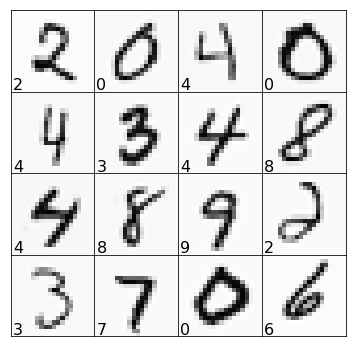

In [32]:
num_fig=16
plt.figure(figsize=(6,6))

for j in range(num_fig):
    plt.subplot(4,4, j+1)
    number=random.randrange(0,m-1,1)
    plt.pcolormesh(np.rot90(ConvertVectorToMatrix(X0[number]),k=1,axes=(0,1)),cmap='Greys')
    plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    
    if pred[number] == 10:
        plt.text(0.5,0.5, '0', fontsize=16)
    else:
        plt.text(0.5,0.5, '%d'%(pred[number]),fontsize=16)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Neural network

## Introduction

In this part, a neural network will be implemented to recognize handwritten digits using the same training set as before. Trained parameters for a neural network are already given in the file "<strong>ex3weights.mat</strong>". Hence, this part of the notebook only shows a code for the feedforward propagation algorithm. 

## Concept

For the sake of simplicity, let us prepare one training data (j-th image) which is a specific row of the matrix X:

$$
   \boldsymbol{a^{(1)}} =
    \boldsymbol{X(j)} =
        \left[\begin{array}{c}
            a_0^{(1)} & x_1^{(j)} & x_2^{(j)} & \dots & x_{n_{pixel}}^{(j)} \\
        \end{array}\right]
            =
                    \left[\begin{array}{c}
            1 & x_1^{(j)} & x_2^{(j)} & \dots & x_{n_{pixel}}^{(j)} \\
        \end{array}\right]\quad,
$$
where the integer j satisfies  
$$
    1 \leq j \leq m.
$$
This is (1 x n)-dimensional vector and called an input layer. 

The input layer is transformed into a hidden layer a<sup>(2)</sup> by using an activation function g(z) and adding a bias term (1) to the first component. In the present case, g(z) is the sigmoid function. 

Let us introduce a parameter &Theta;<sup>(1)</sup>, which is (m<sub>&Theta;<sub>1</sub></sub> x n)-matrix:

$$
    \boldsymbol{\Theta^{(1)}} =
        \left[\begin{array}{c}
            \Theta_{1,1}^{(1)} & \Theta_{1,2}^{(1)} & \dots &  \Theta_{1,n}^{(1)} \\
            \Theta_{2,1}^{(1)} & \Theta_{2,2}^{(1)} & \dots &  \Theta_{2,n}^{(1)} \\
            \vdots & \vdots && \vdots \\            
             \Theta_{m_{\Theta_1},1}^{(1)} & \Theta_{m_{\Theta_1},2}^{(1)} & \dots &  \Theta_{{m_{\Theta_1},n}}^{(1)} \\
        \end{array}\right] \quad,
$$

Multiplication of a<sup>(1)</sup> and &Theta;<sup>(1)</sup> gives

$$
    z^{(2)}=a^{(1)}\Theta^{(1)^T}=
     \left[\begin{array}{c}
            1 & x_1^{(j)} & x_2^{(j)} & \dots & x_{n_{pixel}}^{(j)} \\
        \end{array}\right]
        \left[\begin{array}{c}
            \Theta_{1,1}^{(1)} & \Theta_{2,1}^{(1)} & \dots &  \Theta_{m_{\Theta_1},1}^{(1)} \\
            \Theta_{1,2}^{(1)} & \Theta_{2,2}^{(1)} & \dots &  \Theta_{m_{\Theta_1},2}^{(1)} \\
            \vdots & \vdots && \vdots \\            
             \Theta_{1,n}^{(1)} & \Theta_{2,n}^{(1)} & \dots &  \Theta_{{m_{\Theta_1},n}}^{(1)} \\
        \end{array}\right]
        =
            \left[\begin{array}{c}
            z_1^{(2)} & z_2^{(2)} & \dots & z_{m_{\Theta_1}}^{(2)}\\
        \end{array}\right]\quad,       
$$
which is (1 x m<sub>&Theta;<sub>1</sub></sub>)-dimensional vector. 

The hidden layer is expressed by
$$
    a^{(2)}=
           \left[\begin{array}{c}
            a_0^{(2)} & g(z_1^{(2)}) & g(z_2^{(2)}) & \dots & g(z_{m_{\Theta_1}}^{(2)}) 
        \end{array}\right]\quad,       
$$
where a<sub>0</sub><sup>(2)</sup> is a bias term and set to be 1 in the present notebook. This vector is 1 x (m<sub>&Theta;<sub>1</sub></sub>+1) dimensional vector.

The multiplication of K x (m<sub>&Theta;<sub>1</sub></sub>+1) matrix
$$
    \boldsymbol{\Theta^{(2)}} =
        \left[\begin{array}{c}
            \Theta_{1,1}^{(2)} & \Theta_{1,2}^{(2)} & \dots &  \Theta_{1,m_{\Theta_1}+1}^{(2)} \\
            \Theta_{2,1}^{(2)} & \Theta_{2,2}^{(2)} & \dots &  \Theta_{2,m_{\Theta_1}+1}^{(2)} \\
            \vdots & \vdots && \vdots \\            
             \Theta_{K,1}^{(2)} & \Theta_{K,2}^{(2)} & \dots &  \Theta_{K,m_{\Theta_1}+1}^{(2)} \\
        \end{array}\right] \quad
$$
and the hidden layer gives
$$
 z^{(3)}=a^{(2)}\Theta^{(2)^T}=
      \left[\begin{array}{c}
            a_0^{(2)} & g(z_1^{(2)}) & g(z_2^{(2)}) & \dots & g(z_{m_{\Theta_1}}^{(2)}) 
        \end{array}\right]
       \left[\begin{array}{c}
            \Theta_{1,1}^{(2)} & \Theta_{2,1}^{(2)} & \dots &  \Theta_{K,1}^{(2)} \\
            \Theta_{1,2}^{(2)} & \Theta_{2,2}^{(2)} & \dots &  \Theta_{K,2}^{(2)} \\
            \vdots & \vdots && \vdots \\            
             \Theta_{1,m_{\Theta_1}+1}^{(2)} & \Theta_{2,m_{\Theta_1}+1}^{(2)} & \dots &  \Theta_{K,m_{\Theta_1}+1}^{(2)} \\
        \end{array}\right] 
      =
       \left[\begin{array}{c}
            z_1^{(3)} & z_2^{(3)} & \dots & z_K^{(2)}\\
        \end{array}\right]\quad
$$

Finally, the output layer is obtained by
$$
       a^{(3)}=
       \left[\begin{array}{c}
            g(z_1^{(3)}) & g(z_2^{(3)}) & \dots & g(z_K^{(2)}) \\
        \end{array}\right]\quad,
$$
which is 1 x K vector. In the output layer, each component represents the probability that the input data is classified to a specific class. For example, if K=10 and the input data is assigned to the second group, the output layer looks like
$$
       a^{(3)}=
       \left[\begin{array}{c}
            0&1&0&0&0&0&0&0&0&0 \\
        \end{array}\right]\quad
$$
in an ideal case.

In the present case, integers are ginve as follows:
$$
    n=401, \\
    m=5000, \\
    m_{\Theta_1}=25,\\
    K=10.
$$


## Implementation

In [22]:
from scipy.special import expit

print('The size of X (a1, input layer): %d x %d'%(X.shape[0],X.shape[1]))
a2=expit(np.matmul(X,theta1.T))
a2=np.insert(a2, 0, 1, axis=1)
print('The size of a2 (hidden layer): %d x %d'%(a2.shape[0],a2.shape[1]))
a3=expit(np.matmul(a2,theta2.T))
print('The size of a3 (output layer): %d x %d'%(a3.shape[0],a3.shape[1]))

The size of X (a1, input layer): 5000 x 401
The size of a2 (hidden layer): 5000 x 26
The size of a3 (output layer): 5000 x 10


In [23]:
pred=np.argmax(a3, axis=1)+1
print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel())*100))
print('Expected value: 97.5 %')

Training set accuracy: 97.52 %
Expected value: 97.5 %


In the next cell, several images will be randomly selected and compared with predictions. The predicted numbers will appear on the bottom left. Sometimes the prediction is not correct because the training set accuracy is not 100 %.

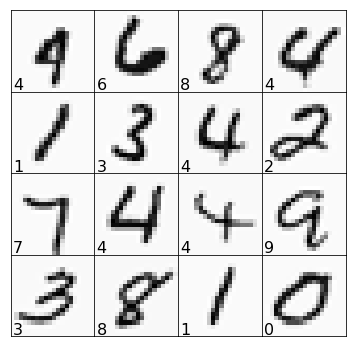

In [33]:
num_fig=16

plt.figure(figsize=(6,6))

for j in range(num_fig):
    plt.subplot(4,4, j+1)
    number=random.randrange(0,m-1,1)
    plt.pcolormesh(np.rot90(ConvertVectorToMatrix(X0[number]),k=1,axes=(0,1)),cmap='Greys')
    plt.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    
    if pred[number] == 10:
        plt.text(0.5,0.5, '0', fontsize=16)
    else:
        plt.text(0.5,0.5, '%d'%(pred[number]),fontsize=16)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()